# Imports and Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton
from scipy.interpolate import CubicSpline
import math
from sympy import Eq, solve, exp, symbols

Bond prices, terms, coupons, and days

In [2]:
bond_prices = np.array([
    [99.63, 99.64, 99.65, 99.66, 99.67, 99.69, 99.68, 99.68, 99.71, 99.72, 99.72],
    [97.96, 97.98, 97.99, 97.98, 98.02, 98.05, 97.97, 97.98, 98, 98.01, 98.03],
    [96.46, 96.48, 96.55, 96.58, 96.66, 96.72, 96.54, 96.45, 96.5, 96.46, 96.46],
    [98.19, 98.20, 98.26, 98.25, 98.31, 98.31, 98.21, 98.02, 97.98, 97.97, 97.9],
    [98.27, 98.28, 98.37, 98.35, 98.43, 98.44, 98.3, 98.05, 98, 97.99, 97.93],
    [93.46, 93.44, 93.55, 93.53, 93.6, 93.57, 93.4, 93.12, 93.08, 93.07, 93],
    [93.28, 93.30, 93.25, 93.19, 93.47, 93.49, 93.14, 92.86, 92.75, 92.76, 92.83],
    [97.58, 97.59, 97.6, 97.52, 97.74, 97.77, 97.44, 97.09, 96.96, 96.95, 96.94],
    [100.5, 100.48, 100.44, 100.33, 100.64, 100.67, 100.22, 99.83, 99.66, 99.62, 99.67],
    [99.74, 99.72, 99.72, 99.55, 99.88, 99.91, 99.44, 98.99, 98.81, 98.77, 98.83]
]).transpose()
terms = np.array([1/6 + i*0.5 for i in range(10)])  # Terms in years
coupons = np.array([0.0225, 0.015, 0.0125, 0.03, 0.03, 0.01, 0.0125, 0.0275, 0.0350, 0.0325]) * 100  # Coupons cash flows
days = ["Jan 8", "Jan 9", "Jan 10", "Jan 11", "Jan 12", "Jan 15", "Jan 16", "Jan 17", "Jan 18", "Jan 19", "Jan 22"]

# YTM Curve

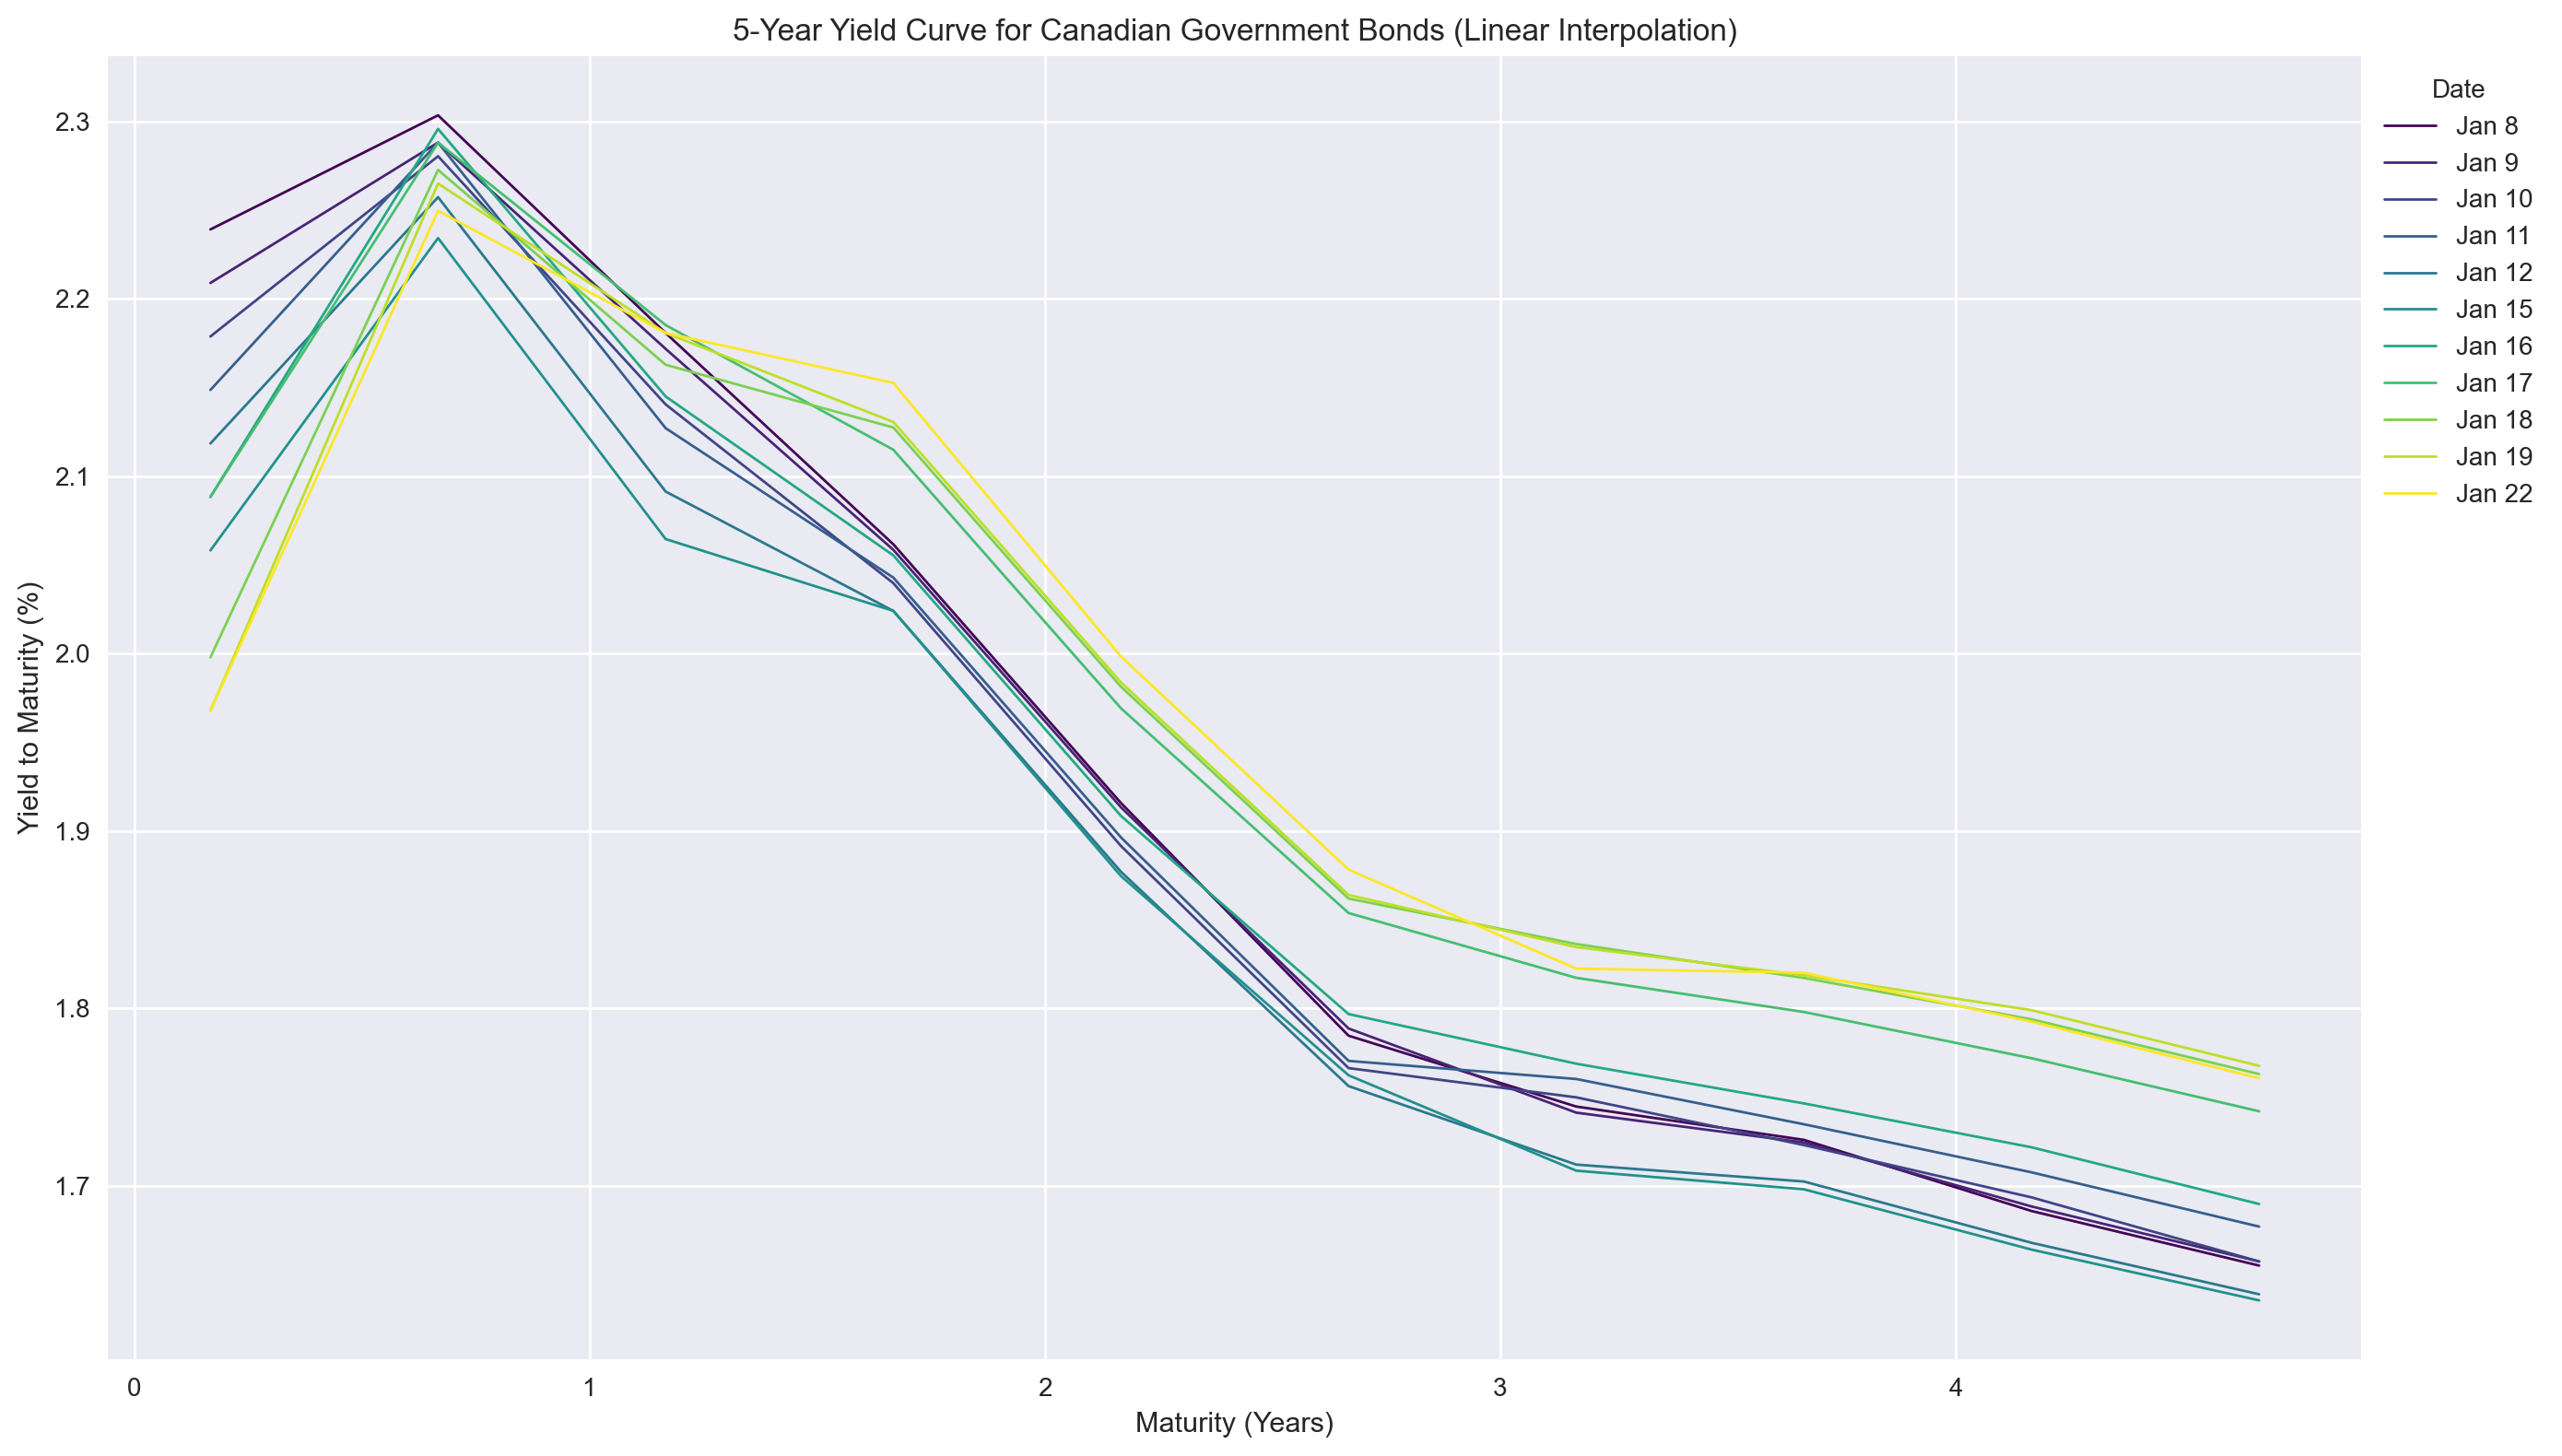

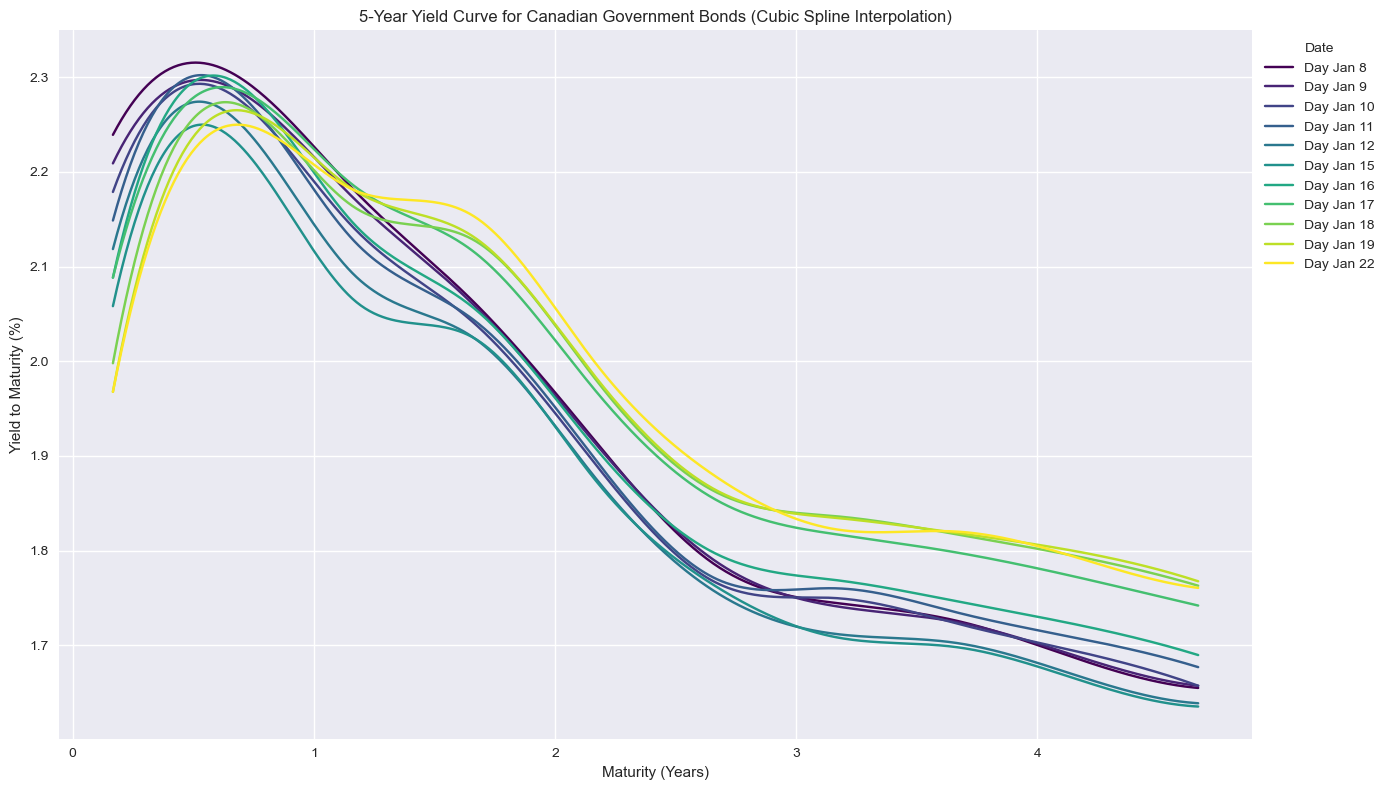

In [3]:
def YTM_numerical(price, coupon, years_to_maturity, face_value=100, guess=0.05):
    # Newton's method to find the YTM
    def price_func(ytm):
        return sum([coupon / (1 + ytm / 2) ** (2 * t) for t in range(1, int(years_to_maturity * 2) + 1)]) + face_value / (1 + ytm / 2) ** (2 * years_to_maturity) - price
    return newton(price_func, guess)


def YTM_simplified(PV, coupons, terms, FV=100):
  # Formula used: YTM = [Annual Coupon + (FV – PV) ÷ Number of Compounding Periods)] ÷ [(FV + PV) ÷ 2]
  n_periods = terms*2
  annual_coupons = coupons * 0.5 # semi annual coupons
  ytm = (annual_coupons + (FV-PV)/n_periods) / (1/2 * (PV+FV))
  #print(PV, coupons)
  return ytm

# Calculate YTM for each bond for each day
YTMs = np.array([[YTM_simplified(price, coupon, term) for price, coupon, term in zip(daily_prices, coupons, terms)] for daily_prices in bond_prices])

# Plotting - Linear Interpolation
colors = plt.cm.viridis(np.linspace(0, 1, len(bond_prices)))
plt.style.use('seaborn')
plt.figure(figsize=(14,8), dpi=200)
for i, SRs in enumerate(YTMs):
    plt.plot(terms, SRs * 100, label=f"{days[i]}", linewidth=1, color=colors[i])
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield to Maturity (%)")
plt.title("5-Year Yield Curve for Canadian Government Bonds (Linear Interpolation)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Date")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting - Cubic Spline Interpolation
plt.figure(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(bond_prices)))
for i, (ytm_day, color) in enumerate(zip(YTMs, colors)):
    cs = CubicSpline(terms, ytm_day)
    xs = np.linspace(terms[0], terms[-1], 500)
    ys = cs(xs)
    plt.plot(xs, ys * 100, label=f"Day {days[i]}", color=color)  # Convert YTM to percentage

plt.title("5-Year Yield Curve for Canadian Government Bonds (Cubic Spline Interpolation)")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield to Maturity (%)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Date")
plt.grid(True)
plt.tight_layout()
plt.show()

# Spot Rate Curve

In [4]:

def cal_spot_rate(DRs, terms, coupons):
    daily_SR = []
    r = symbols('r')  # Define the symbol for the rate
    for i, t in enumerate(terms):
        dp = DRs[i]
        coupon = coupons[i] * 0.5  # Convert annual coupon rate to semi-annual
        
        if i > 0:
            constant = sum(coupon * exp(-past_r * past_t) for (past_r, past_t) in zip(daily_SR, terms[:i]))
        else:
            constant = 0  # For the first bond, which is a zero-coupon bond
        
        eqn = Eq(dp, constant + (100 + coupon) * exp(-r * t))
        solution = solve(eqn, r, dict=True)[0][r]*100
        daily_SR.append(solution)
    return daily_SR

SRs = [] # Spot rates
for i, daily_price in enumerate(bond_prices):
    DRs = daily_price + 59/365 * coupons  # Dirty Price, Add the accrued interest
    daily_SR = cal_spot_rate(DRs, terms, coupons) # Convert to percentage
    SRs.append(daily_SR)


Generate the Spot Curve

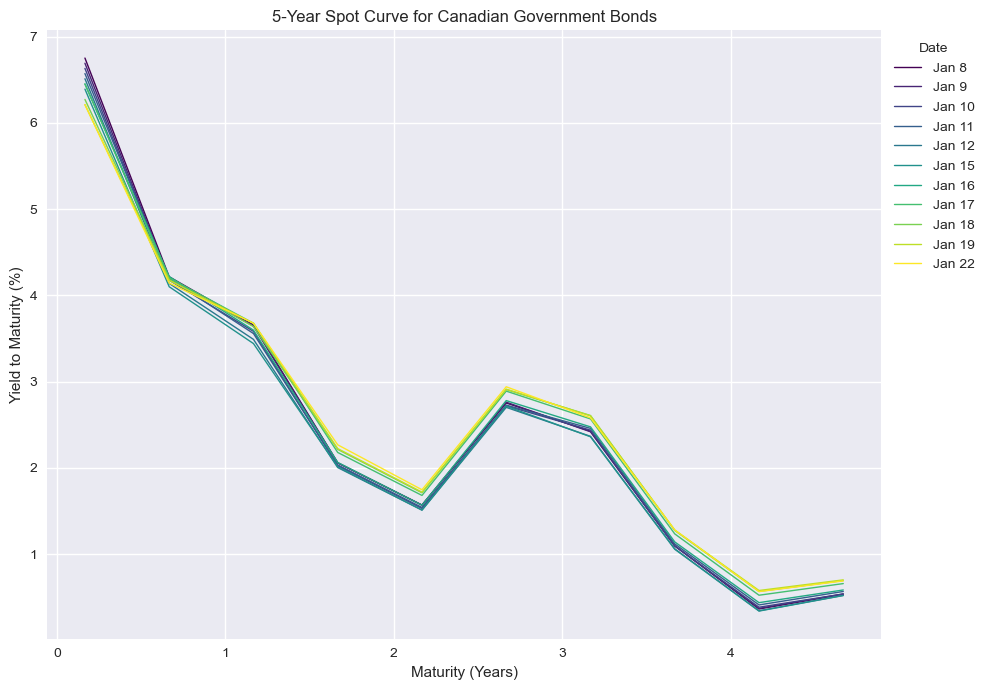

In [5]:
colors = plt.cm.viridis(np.linspace(0, 1, len(SRs)))
plt.style.use('seaborn')
plt.figure(figsize=(10,7), dpi=100)
for i, SR in enumerate(SRs):
    plt.plot(terms, SR, label=f"{days[i]}", linewidth=1, color=colors[i])
plt.title("5-Year Spot Curve for Canadian Government Bonds")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield to Maturity (%)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Date")
plt.grid(True)
plt.tight_layout()
plt.show()

# Forward Rate

In [6]:
def cal_forward_rate(spot_rates, terms, forward_indices, base_index=0): # base_index=0 refers to Mar. 2024, the first year
    FRs = []
    for i in forward_indices:
        # Calculate the forward rate using the formula for discrete compounding
        r_b = spot_rates[base_index]
        t_b = terms[base_index]
        r_a = spot_rates[i]
        t_a = terms[i]

        # Calculate forward rate using the formula (1 + f)^{t_a-t_b} = (1 + r_a)^{t_a} / (1 + r_b)^{t_b}
        # and then solve for f
        f = ((1 + r_a)**t_a / (1 + r_b)**t_b)**(1/(t_a-t_b)) - 1
        FRs.append(f)
    return FRs

In [7]:
FRs = [] # Forward rates
forward_indices = [2,4,6,8] # Forward rates for 2, 3, 4, 5 years

for i, spot_rate in enumerate(SRs):
  FR = cal_forward_rate(spot_rate, terms, forward_indices)
  FRs.append(FR)

Generate the Forward Curve

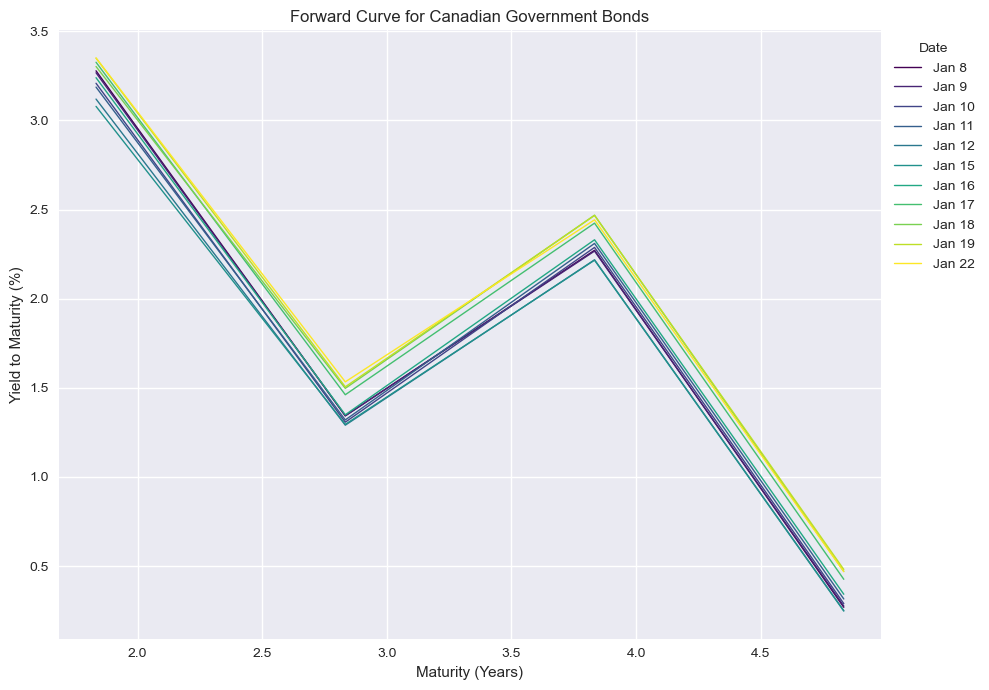

In [8]:
colors = plt.cm.viridis(np.linspace(0, 1, len(SRs)))
plt.style.use('seaborn')
plt.figure(figsize=(10,7), dpi=100)
for i, rates in enumerate(FRs):
    plt.plot([terms[k]+2/3 for k in forward_indices], rates, label=f"{days[i]}", linewidth=1, color=colors[i])
plt.title("Forward Curve for Canadian Government Bonds")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield to Maturity (%)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Date")
plt.grid(True)
plt.tight_layout()
plt.show()

# Covariance Matrices

In [9]:
def rate_to_log_return(rates):
  # Formula: ret_ij = log(r_i(j+1)) - log(r_ij)
  rates_np = np.array(rates).T # Transpose the rates back
  log_return = []
  for rates in rates_np:
    log_r0 = math.log(rates[0])
    
    # Calculate the daily log returns for each yield rate across the next 9 days, hopefully
    ret = [math.log(rate) - log_r0 for rate in rates[1:]] 
    log_return.append(ret)
  log_return = np.array(log_return)
  return log_return


In [10]:
YTMs_log_return = rate_to_log_return(YTMs)
YTMs_log_return = [YTMs_log_return[2*i] for i in range(len(YTMs_log_return)//2)]

FRs_log_return = rate_to_log_return(FRs)

YTMs_Cov = np.cov(YTMs_log_return)
FRs_Cov = np.cov(FRs_log_return)

print(f"YTMs Covariance Matrix: \n{YTMs_Cov}") # Should be 10x10   
print(f"FRs Covariance Matrix: \n{FRs_Cov}") # Should be 4x4

YTMs Covariance Matrix: 
[[ 0.00167588 -0.00019745 -0.00074479 -0.00077016 -0.00096259]
 [-0.00019745  0.0003656   0.00039103  0.00043735  0.00047131]
 [-0.00074479  0.00039103  0.00062137  0.00066061  0.0007572 ]
 [-0.00077016  0.00043735  0.00066061  0.00076795  0.00085853]
 [-0.00096259  0.00047131  0.0007572   0.00085853  0.00097434]]
FRs Covariance Matrix: 
[[0.00086149 0.00180879 0.00112286 0.00702683]
 [0.00180879 0.00478355 0.00280634 0.01789939]
 [0.00112286 0.00280634 0.00180445 0.01136392]
 [0.00702683 0.01789939 0.01136392 0.07207153]]


# Eigenvalues and Eigenvectors

In [11]:
def eigen(cov_matrix):
  eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

  # Sort the eigenvalues and eigenvectors
  idx = eigenvalues.argsort()[::-1]
  sorted_eigenvalues = eigenvalues[idx]
  sorted_eigenvectors = eigenvectors[:,idx]

  # Take the top 5 in value
  largest_eigenvalues_5 = sorted_eigenvalues[:5]
  largest_eigenvec_5 = sorted_eigenvectors[:,:5]

  return largest_eigenvalues_5, largest_eigenvec_5, eigenvalues, eigenvectors

In [12]:
# Top 5 eigenvalues and eigenvectors for YTMs
largest_eigenvalues_5, largest_eigenvec_5, eigenvalues, eigenvectors = eigen(YTMs_Cov)


print(f"ALL eigenvalues: {eigenvalues}")
print(f"ALL eigenvectors: {eigenvectors}")

print(f"Largest 5 eigenvalues: {largest_eigenvalues_5}")
print(f"Largest 5 eigenvectors: {largest_eigenvec_5}")

ALL eigenvalues: [3.63369271e-03 7.17605039e-04 4.19864416e-05 1.12718186e-05
 5.83221572e-07]
ALL eigenvectors: [[-0.59255704 -0.74496199  0.15960604 -0.24497876  0.09175567]
 [ 0.21448917 -0.50437852 -0.511304    0.65916336 -0.0605688 ]
 [ 0.39695066 -0.20861168 -0.53196208 -0.71087853 -0.10285622]
 [ 0.43507088 -0.30470655  0.56234333  0.00324362 -0.63374025]
 [ 0.50597831 -0.23295712  0.33746179 -0.01141313  0.75875306]]
Largest 5 eigenvalues: [3.63369271e-03 7.17605039e-04 4.19864416e-05 1.12718186e-05
 5.83221572e-07]
Largest 5 eigenvectors: [[-0.59255704 -0.74496199  0.15960604 -0.24497876  0.09175567]
 [ 0.21448917 -0.50437852 -0.511304    0.65916336 -0.0605688 ]
 [ 0.39695066 -0.20861168 -0.53196208 -0.71087853 -0.10285622]
 [ 0.43507088 -0.30470655  0.56234333  0.00324362 -0.63374025]
 [ 0.50597831 -0.23295712  0.33746179 -0.01141313  0.75875306]]


In [13]:
# Top 5 eigenvalues and eigenvectors for Forward Rates
largest_eigenvalues_5, largest_eigenvec_5, eigenvalues, eigenvectors = eigen(FRs_Cov)
print(f"Largest 5 eigenvalues: {largest_eigenvalues_5}")
print(f"Largest 5 eigenvectors: {largest_eigenvec_5}")

Largest 5 eigenvalues: [7.90168924e-02 3.37873280e-04 1.56748583e-04 9.51238671e-06]
Largest 5 eigenvectors: [[ 0.09352992  0.30436881 -0.94114763 -0.11337073]
 [ 0.23821959  0.91709978  0.31176106  0.0706007 ]
 [ 0.15055824 -0.07156434 -0.12598282  0.97792591]
 [ 0.95490094 -0.24731794  0.03427122 -0.160697  ]]


# Archived Code